In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
S = 100
K = 100
B = 200
r = 0.05
sigma = 0.1
T = 1
t = 0
M = 100
N = 1000

Tusk: Program the formula for the exact price of a barrier up-and-out call

In [3]:
def d1(dt, s):    
    return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r + 0.5 * sigma ** 2) * dt))
def d2(dt, s):
    return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r - 0.5 * sigma ** 2) * dt))
def up_and_out_call_by_formula(t, x, B, sigma, r):    
    dt = T - t
    V = x * (norm.cdf(d1(dt, x/K)) - norm.cdf(d1(dt, x/B))) - np.exp(-r*dt) * K * ((norm.cdf(d2(dt, x/K))) - norm.cdf(d2(dt, x/B))) - B * np.power(x/B, -2*r/(sigma**2)) * (norm.cdf(d1(dt, (B**2)/K/x)) - norm.cdf(d1(dt, B/x))) + np.exp(-r*dt) * K * np.power(x/B, -2*r/(sigma**2) + 1) * ((norm.cdf(d2(dt, B**2/K/x))) - norm.cdf(d2(dt, B/x)))
    return V

In [4]:
def get_up_and_out_call_V(S, K, B, T, N, M, r, sigma):
    tau, dt = np.linspace(0, T, N, retstep=True)
    xt, dx = np.linspace(0, B, M, retstep=True)
    a = pd.DataFrame(np.zeros((N, M)),columns=xt, index = tau)
    for j in range(0, N):
            for i in range(1, M - 1):
                a.iloc[j, i] = up_and_out_call_by_formula(tau[j], xt[i], B, sigma, r)
    return a

In [5]:
a = get_up_and_out_call_V(S, K, B, T, N, M, r, sigma)

C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_9504\3866436242.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r + 0.5 * sigma ** 2) * dt))
C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_9504\3866436242.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r - 0.5 * sigma ** 2) * dt))


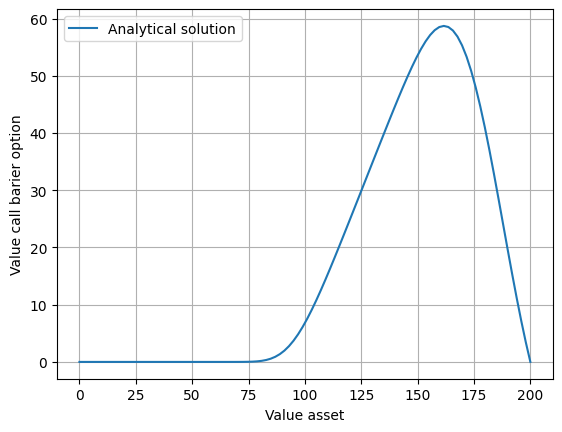

In [6]:
st, dx = np.linspace(0, B, M, retstep=True)
plt.plot(st, a.iloc[0], label='Analytical solution')
plt.xlabel("Value asset")
plt.ylabel("Value call barier option")
plt.grid()
plt.legend()
plt.show()


Tusk: Find the cost of a barrier up-and-out call using the Monte Carlo method and compare
with exact price.

In [7]:
def Probability(B, K, T):
    return 1 - np.exp(2 * B * (K-B) / T)

def Up_and_out_Call_by_Monte_Carlo(N, S, K, B, T, t, M, r, sigma):
    Ci = []
    for i in range(N):
        Z = norm.rvs(size=1)
        x = S * np.exp((r - (sigma ** 2)/2)*T + sigma * np.sqrt(T)*Z)
        if (x-K) > 0:
            Ci.append(np.exp(-1*r*T) * (x-K) * Probability(B, K , T-t))
        else:
            Ci.append(0)
    Cn = sum(Ci)/len(Ci)
    return Cn


In [8]:
payoff = up_and_out_call_by_formula(t, S, B, sigma, r)
for i in range(5):
    Monte_Carlo_payoff = Up_and_out_Call_by_Monte_Carlo(1000000, S, K, B, T, t, M, r, sigma)[0]
    print("value calculated by formula =", payoff)
    print("value calculated by Monte Carlo =", Monte_Carlo_payoff)
    print("relative error =", abs(Monte_Carlo_payoff - payoff)/Monte_Carlo_payoff)

value calculated by formula = 6.804957700658515
value calculated by Monte Carlo = 6.801991540255804
relative error = 0.00043607234515904893
value calculated by formula = 6.804957700658515
value calculated by Monte Carlo = 6.802830459381904
relative error = 0.00031269944022744043
value calculated by formula = 6.804957700658515
value calculated by Monte Carlo = 6.808757568750147
relative error = 0.0005580853853678574
value calculated by formula = 6.804957700658515
value calculated by Monte Carlo = 6.789648632313805
relative error = 0.002254765919969646
value calculated by formula = 6.804957700658515
value calculated by Monte Carlo = 6.801231620383043
relative error = 0.0005478537540619874


Tusk: Numerically Solve (explicit scheme) the Blake-Scholes Equation for the Barrier Up-and-Out
call and compare with exact price. $V_t(t,x) + rxV_x(t,x) + \frac{1}{2}\sigma^2x^2V_xx(t,x) = rV(t,x)$

In [9]:
def explicit_sheme_up_and_out_call(S, K, B, M, N, T, t, r, sigma):
    st = np.linspace(0.1, S * 3, M)
    tau, dt = np.linspace(0, T, N, retstep=True)
    xt, dx = np.linspace(0, B, M, retstep=True)
    u = pd.DataFrame(np.zeros((N, M)),columns=xt, index = tau)
    for i in range(0, M):
        if (xt[i] - K) > 0:
            u.iloc[N-1][i] = xt[i] - K 

    for j in range(N-1, 0, -1):
        for i in range(1, M - 1):
            u.iloc[j - 1, i] = r * xt[i] * dt * ((u.iloc[j, i + 1] - u.iloc[j, i - 1]) / dx / 2)\
                    + 1 / 2 * sigma ** 2 * dt * xt[i] ** 2 * ((u.iloc[j, i - 1] - 2 * u.iloc[j, i] + u.iloc[j, i + 1]) / dx  ** 2)\
                        - (r *  dt - 1) * u.iloc[j, i]
    return u, xt

C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_9504\1952280573.py:8: FutureWarning: Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.
  u.iloc[N-1][i] = xt[i] - K
C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_9504\3866436242.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r + 0.5 * sigma ** 2) * dt))
C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_9504\3866436242.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return (1/(sigma * np.sqrt(dt)) *(np.log(s) + (r - 0.5 * sigma ** 2) * dt))


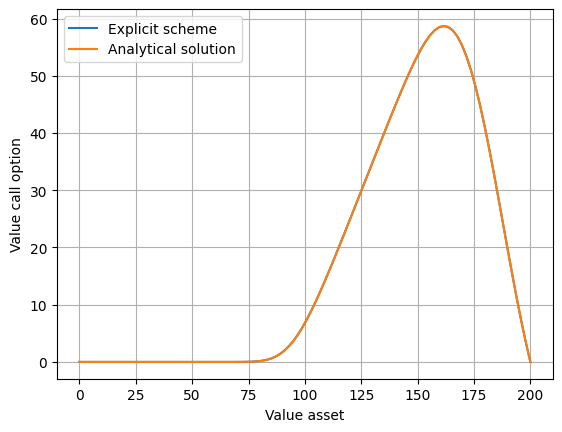

In [10]:
u, xt = explicit_sheme_up_and_out_call(S, K, B, M, N, T, t, r, sigma)
a = get_up_and_out_call_V(S, K, B, T, N, M, r, sigma)
plt.plot(xt, u.iloc[0], label='Explicit scheme')
plt.plot(xt, a.iloc[0], label='Analytical solution')
plt.xlabel("Value asset")
plt.ylabel("Value call option")
plt.grid()
plt.legend()
plt.show()

Tusk: Program lookback price formula option with variable strike

In [11]:
def look_back_option(t, z, r, sigma):
    tau = T - t
    u = (1 + sigma**2/(2*r)) * z * norm.cdf(d1(tau, z)) + np.exp(-r * tau) * norm.cdf(- d2(tau, z)) - sigma**2/(2*r) * np.exp(-r * tau) * np.power(z, 1 - 2*r/(sigma**2)) * norm.cdf(- d2(tau, 1/z)) - z
    return u

def get_look_back_option(T, N, M, r, sigma):
    tau, dt = np.linspace(0, T, N, retstep=True)
    z, dx = np.linspace(0.000000001, 1, M, retstep=True)
    a = pd.DataFrame(np.zeros((N, M)),columns=z, index = tau)
    for j in range(0, N-1):
            for i in range(0, M):
                a.iloc[j, i] = look_back_option(tau[j], z[i], r, sigma)
    return a

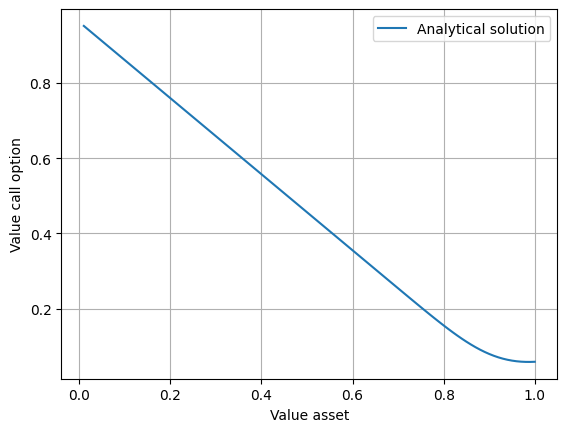

In [12]:
a = get_look_back_option(T, N, M, r, sigma)
z, dx = np.linspace(0.01, 1, M, retstep=True)
plt.plot(z, a.iloc[0], label='Analytical solution')
plt.xlabel("Value asset")
plt.ylabel("Value call option")
plt.grid()
plt.legend()
plt.show()

Tusk: Find the cost of a look back option using the Monte Carlo method and compare with exact price.

In [13]:
def Monte_Carlo_lookback(S, T, N, M , r, sigma):
    dt = T/M
    Ci = []
    for i in range(N):
        max_S = S
        x = [S]
        for j in range(1, M+1):
            Si = x[-1]
            dS = Si * (r * dt + sigma * norm.rvs(size=1) * np.sqrt(dt))
            x.append(Si + dS)
            if x[-1] > max_S: 
                max_S = x[-1] 
        Ci.append(np.exp(-1*r*T) * (max_S - x[-1]))
    Cn = sum(Ci)/len(Ci)
    return Cn

In [14]:
payoff = S * look_back_option(t, 1, r, sigma)
for i in range(0, 5):
    Monte_Carlo_payoff = Monte_Carlo_lookback(S, T, 1000, 1000 , r, sigma)
    print("value calculated by formula =", payoff)
    print("value calculated by Monte Carlo =", Monte_Carlo_payoff[0])
    print("relative error =", abs(Monte_Carlo_payoff[0] - payoff)/Monte_Carlo_payoff[0])

value calculated by formula = 5.911916407237272
value calculated by Monte Carlo = 5.673463112214325
relative error = 0.04202958410174276
value calculated by formula = 5.911916407237272
value calculated by Monte Carlo = 5.795702516655842
relative error = 0.020051734927293376
value calculated by formula = 5.911916407237272
value calculated by Monte Carlo = 5.793775472662135
relative error = 0.020391010168168137
value calculated by formula = 5.911916407237272
value calculated by Monte Carlo = 5.781602292401025
relative error = 0.02253944637588167
value calculated by formula = 5.911916407237272
value calculated by Monte Carlo = 5.66497518700388
relative error = 0.04359087411360676


Tusk: Find the cost of a look back option using the Monte Carlo method and compare with exact price. $U_t(t,z) + rxU_z(t,z) + \frac{1}{2}\sigma^2z^2U_zz(t,z) = rU(t,z)$, $z\in[0, 1]$

In [15]:
def explicit_sheme_look_back_option(M, N, T, t, r, sigma):
    tau, dt = np.linspace(0, T, N, retstep=True)
    z, dx = np.linspace(0.000000001, 1, M, retstep=True)
    u = pd.DataFrame(np.zeros((N, M)),columns=z, index = tau)
    for i in range(0, M):
        u.iloc[N-1, i] = 1 - z[i]
    for j in range(0, N):
        u.iloc[j, 0] = np.exp(-r * (T - tau[j]))

    for j in range(N-1, 0, -1):
        for i in range(1, M - 1):
            u.iloc[j - 1, i] = + r * z[i] * dt * ((u.iloc[j, i + 1] - u.iloc[j, i - 1]) / dx / 2)\
                    + 1 / 2 * sigma ** 2 * dt * z[i] ** 2 * ((u.iloc[j, i - 1] - 2 * u.iloc[j, i] + u.iloc[j, i + 1]) / dx  ** 2)\
                        - (r *  dt - 1) * u.iloc[j, i]
        u.iloc[j - 1, M - 1] =  u.iloc[j - 1, M - 2] * (dx + 1)
    return u, z

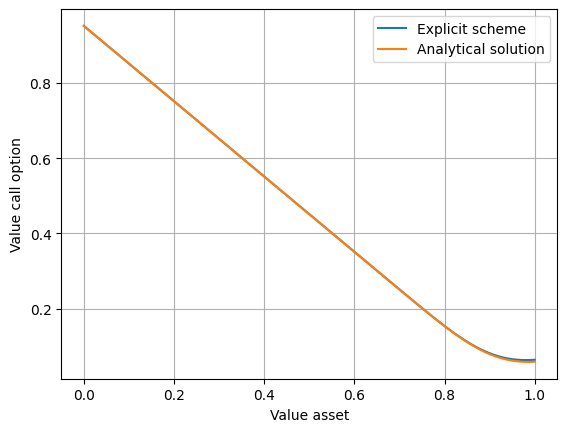

In [16]:
u, z = explicit_sheme_look_back_option(M, N, T, t, r, sigma)
a = get_look_back_option(T, N, M, r, sigma)
plt.plot(z, u.iloc[0], label='Explicit scheme')
plt.plot(z, a.iloc[0], label='Analytical solution')
plt.xlabel("Value asset")
plt.ylabel("Value call option")
plt.grid()
plt.legend()
plt.show()

Tusk: Draw a graph of the density $p(t)= \frac{B}{t\sqrt{2t\pi}} \exp^{\frac{-B^2}{2t}}$ of the moment $\tau_m$ of reaching the barrier B and find its maximum point.

In [17]:
def density(B, tau_m):
    return B/(tau_m * np.sqrt(2*np.pi * tau_m)) * np.exp(-B**2/2/tau_m)

def get_density(B, T):
    tau = np.linspace(0.00001, T * 10000, N * 10000)
    pmax = 0
    tmax = 0
    distribution = []
    for tau_m in tau:
        density1 = density(B, tau_m)
        distribution.append(density1)
        if (density1 > pmax):
            pmax = density1
            tmax = tau_m
    return distribution, tau, pmax, tmax

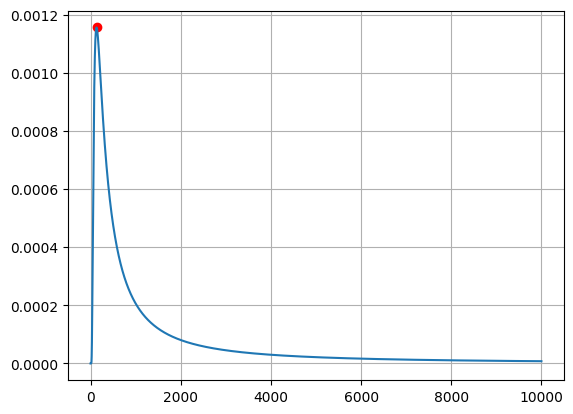

Maximum = 133.33302319996835 0.0011563524735235774


In [18]:
B = 20
distribution, tau, pmax, tmax = get_density(B, T)
plt.plot(tau, distribution)
plt.grid()
plt.scatter(tmax, pmax, color = "red")
plt.show()

print("Maximum =", tmax, pmax)

Tusk: Solve numerically the equation in partial derivatives. Calculate using the function the price of the Asian option and compare with the price,
calculated by the Monte Carlo method. $g_t(t,x) + \frac{1}{2}\sigma^2(\gamma(t) - x^2)g_{xx} (t,x) = 0$, $\gamma(t) = \frac{1}{rT}(1-\exp^{-r(T-t)})$

In [19]:
def explicit_sheme_azian_option(S, M, N, T, t, r, sigma):
    tau, dt = np.linspace(0, T, N, retstep=True)
    x0 = (1 / r / T * (1 - np.exp(-r * T)) * S - K * np.exp(-r * T)) / S
    xt = np.linspace(0, 0, M)
    dx = 2 / M
    for i in range(0, M):
        xt[i] = - 1 + x0 + 2/M * i     
    u = pd.DataFrame(np.zeros((N, M)),columns=xt, index = tau)
    for i in range(0, M):
        if xt[i] > 0:
            u.iloc[N-1, i] = xt[i]
    for j in range(0, N):
        u.iloc[j, M-1] = xt[M-1]
    gamma = np.linspace(0,0,N)
    for i in range(0, N):
        gamma[i] = 1 / r / T * (1 - np.exp(-r * (T - tau[i])))

    for j in range(N-1, 0, -1):
        for i in range(1, M - 1):
            u.iloc[j - 1, i] = u.iloc[j, i] + abs(dt) * sigma ** 2 / 2 * (gamma[j] - xt[i]) ** 2 * ((u.iloc[j, i - 1] - 2 * u.iloc[j, i] + u.iloc[j, i + 1]) / dx  ** 2)
    return u, xt, x0

def value_asiatic_option_Monte_Carlo(S0, K, r, sigma, T, N, M):
    S = np.zeros((N, M + 1))
    z = norm.rvs(size=(N, M))
    sr = np.zeros(N)
    c = np.zeros(N)
    csum = 0
    for j in range(N):
        S[j, 0] = S0
        sumsr = 0
        for i in range(M):
            S[j, i + 1] = S[j, i] * np.exp((r - sigma ** 2 / 2) * (T / M) + sigma * np.sqrt(T / M) * z[j, i])
            sumsr +=  S[j, i+1]
            sr[j] = sumsr/M
            if (sr[j] - K) > 0:
                c[j] = (sr[j] - K) * np.exp(-r * T)
            else:
                c[j] = 0
        csum += c[j]
    return csum / N


Value azian_option by scheme= 3.629293747716607
Value azian_option by Monte Carlo= 3.510901784563153


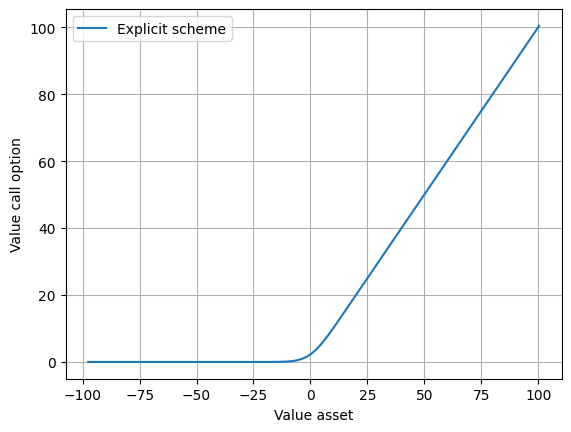

In [20]:
M = 100
N = 1000
u, xt, x0 = explicit_sheme_azian_option(S, M, N, T, t, r, sigma)
a = value_asiatic_option_Monte_Carlo(S, K, r, sigma, T, N, M)
vt = np.linspace(0,0,M)
for i in range(0, M):
    vt[i] =  u.iloc[0, i] * S
    xt[i] = xt[i] * S
print('Value azian_option by scheme=',vt[50])
print('Value azian_option by Monte Carlo=',a)
plt.plot(xt, vt, label='Explicit scheme')
plt.xlabel("Value asset")
plt.ylabel("Value call option")
plt.grid()
plt.legend()
plt.show()